Small neural network which generates Russian names.\
Source of the names https://github.com/Raven-SL/ru-pnames-list

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('runames.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

1674
15
['Аарон', 'Аба', 'Аббас', 'Абд аль-Узза', 'Абдуллах', 'Абид', 'Аботур', 'Аввакум']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: '-', 3: 'А', 4: 'Б', 5: 'В', 6: 'Г', 7: 'Д', 8: 'Е', 9: 'Ж', 10: 'З', 11: 'И', 12: 'Й', 13: 'К', 14: 'Л', 15: 'М', 16: 'Н', 17: 'О', 18: 'П', 19: 'Р', 20: 'С', 21: 'Т', 22: 'У', 23: 'Ф', 24: 'Х', 25: 'Ц', 26: 'Ч', 27: 'Ш', 28: 'Э', 29: 'Ю', 30: 'Я', 31: 'а', 32: 'б', 33: 'в', 34: 'г', 35: 'д', 36: 'е', 37: 'ж', 38: 'з', 39: 'и', 40: 'й', 41: 'к', 42: 'л', 43: 'м', 44: 'н', 45: 'о', 46: 'п', 47: 'р', 48: 'с', 49: 'т', 50: 'у', 51: 'ф', 52: 'х', 53: 'ц', 54: 'ч', 55: 'ш', 56: 'ы', 57: 'ь', 58: 'э', 59: 'ю', 60: 'я', 61: 'ё', 0: '.'}
62


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([9975, 8]) torch.Size([9975])
torch.Size([1245, 8]) torch.Size([1245])
torch.Size([1213, 8]) torch.Size([1213])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> Ф
.......Ф --> р
......Фр --> и
.....Фри --> д
....Фрид --> р
...Фридр --> и
..Фридри --> х
.Фридрих --> .
........ --> Х
.......Х --> и
......Хи --> о
.....Хио --> н
....Хион --> и
...Хиони --> я
..Хиония --> .
........ --> А
.......А --> в
......Ав --> д
.....Авд --> е
....Авде --> й


In [7]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42); # seed rng for reproducibility

In [9]:
# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

81934


In [10]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
logits = model(Xb)
print (Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  8, 33],
        [ 0,  0,  0,  0,  0,  0,  0, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  3],
        [ 0,  0,  0,  0,  0, 23, 36, 45]])

In [11]:
for layer in model.layers:
    print (layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 62)


In [12]:
# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []
loss_val = []
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        logits_val = model(Xdev)
        loss_val_singl = F.cross_entropy(logits_val, Ydev)
        loss_val.append(loss_val_singl.log10().item())
    lossi.append(loss.log10().item())

      0/   2000: 4.1234
    100/   2000: 2.5594
    200/   2000: 2.3083
    300/   2000: 2.5153
    400/   2000: 2.3035
    500/   2000: 1.8289
    600/   2000: 2.1471
    700/   2000: 2.1339
    800/   2000: 2.0696
    900/   2000: 2.1902
   1000/   2000: 2.0926
   1100/   2000: 1.8077
   1200/   2000: 2.1084
   1300/   2000: 2.3703
   1400/   2000: 2.0186
   1500/   2000: 1.9258
   1600/   2000: 1.8307
   1700/   2000: 2.2470
   1800/   2000: 2.1943
   1900/   2000: 2.2654


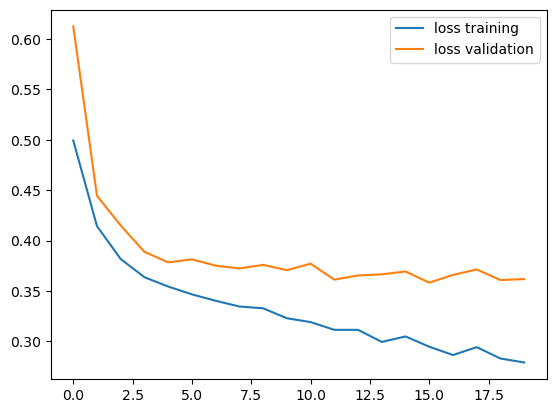

In [13]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1), label = "loss training")
plt.plot(loss_val, label = "loss validation")
plt.legend()

In [14]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [15]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8754817247390747
val 2.332451343536377


In [16]:
# sample from the model
for _ in range(50):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        # if we sample the special '.' token, break
        if ix == 0:
            break
        out.append(ix)

    strname = ''.join(itos[i] for i in out) 
    print (strname + (' '*(20-len(strname))) + "\t" + str(strname in words)) #prints true if name were in dataset

Сцлав               	False
Пургудий            	False
Гальмира            	False
Альгрста            	False
Авелла              	False
Савира              	False
Вальдий             	False
ЭрриконаЮа          	False
Лайнент             	False
Раильдера           	False
йлавиел             	False
Картандта           	False
Антина              	False
Орика               	False
Дисламё             	False
Агельгеда           	False
Катилпнерьян        	False
Юсия                	False
Натамира            	False
Феонила             	False
Руна                	False
Артун               	False
Клесса              	False
Ерислав             	False
Генасия             	False
Лузьо               	False
Асана               	False
Барислав            	False
Алина               	True
Маркур              	False
Зинен               	False
Даина               	False
Фульверия           	False
Берксуна            	False
Агарь               	True
Фльда               	False
Волинан             	False
Иуа